# How to work with CMEMS reanalysis on Earth Data Hub
### Analysis of el Nino events

***
This notebook will provide you guidance on how to access and use the `cmems_mod_glo_phy_my_0.083_P1D-m.zarr` datset on Earth Data Hub.

The first goal is to compute the average anomaly of the Sea Surface Height over the Pacific equator region during the 1997-1998 El Nino event. We will use the whole time range provided by the dataset as a reference period.

The second goal is to highlight other occurences of El Nino in the available time span.
***

## What you will learn:

* how to access and preview the dataset
* select and reduce the data
* plot the results

## Data access and preview
***

Xarray and Dask work together following a lazy principle. This means when you access and manipulate a Zarr store the data is in not immediately downloaded and loaded in memory. Instead, Dask constructs a task graph that represents the operations to be performed. A smart user will reduce the amount of data that needs to be downloaded before the computation takes place (e.g., when the `.compute()` or `.plot()` methods are called).

To preview the data, only the dataset metadata must be downloaded. Xarray does this automatically:

***

In [1]:
import xarray as xr

ds = xr.open_dataset("s3://cmems-reanalysis/cmems_mod_glo_phy_my_0.083_P1D-m.zarr", chunks={}, engine="zarr").astype("float32")
ds

<xarray.Dataset>
Dimensions:    (time: 10227, latitude: 2041, longitude: 4320, depth: 50)
Coordinates:
  * depth      (depth) float32 0.494 1.541 2.646 ... 5.275e+03 5.728e+03
  * latitude   (latitude) float32 -80.0 -79.92 -79.83 ... 89.83 89.92 90.0
  * longitude  (longitude) float32 -180.0 -179.9 -179.8 ... 179.8 179.8 179.9
  * time       (time) datetime64[ns] 1993-01-01T12:00:00 ... 2020-12-31T12:00:00
Data variables:
    bottomT    (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    mlotst     (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    siconc     (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    sithick    (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    usi        (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    vsi        (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(120, 128, 256), meta=np.ndarray>
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-01-06 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

## Working with data

Datasets on EDH are typically very large and remotely hosted. Typical use imply a selection of the data followed by one or more reduction steps to be performed in a local or distributed Dask environment. 

The structure of a workflow that uses EDH data looks like this:
1. data selection
2. (optional) data reduction
3. (optional) visualization

## Sea Surface Height anomaly: 1997-1998 El Nino event

### 1. Data selection

From the original dataset we extract the sea surface height (variable `zos`) and perform a geographical selection corresponding to the Pacific equator area. This greatly reduces the amount of data that will be downloaded from EDH.

In [2]:
zos_pacific_area = ds.zos.sel(**{"latitude": slice(-5, 5), "longitude": slice(-120, -80)})
zos_pacific_area

<xarray.DataArray 'zos' (time: 10227, latitude: 121, longitude: 481)>
dask.array<getitem, shape=(10227, 121, 481), dtype=float32, chunksize=(120, 121, 256), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 -5.0 -4.917 -4.833 -4.75 ... 4.833 4.917 5.0
  * longitude  (longitude) float32 -120.0 -119.9 -119.8 ... -80.17 -80.08 -80.0
  * time       (time) datetime64[ns] 1993-01-01T12:00:00 ... 2020-12-31T12:00:00
Attributes:
    _ChunkSizes:               [1, 681, 1440]
    cell_methods:              area: mean
    last_restart_dim_updated:  10227
    long_name:                 Sea surface height
    standard_name:             sea_surface_height_above_geoid
    unit_long:                 Meters
    units:                     m
    valid_max:                 5039
    valid_min:                 -6181

!NB. At this point, no data has been downloaded yet, nor loaded in memory

### 2. Data reduction

We compute the mean sea surface height, in the Pacific area, over the reference period (1993-2020):

In [3]:
zos_pacific_area_1993_2020_mean = zos_pacific_area.mean(dim="time")

After that, we can compute the sea surface height anomaly in the same area.
Calling `compute` on the result will trigger the download and computation.

We can mesure the time it takes:

In [4]:
%%time

zos_pacific_area_anomaly = zos_pacific_area - zos_pacific_area_1993_2020_mean
zos_pacific_area_anomaly = zos_pacific_area_anomaly.compute()

CPU times: user 32.8 s, sys: 13.2 s, total: 46 s
Wall time: 3min 22s


We further select only the time span realative to the El Nino event, and compute the sea surface height mean:

In [5]:
zos_pacific_area_anomaly_1997_1998 = zos_pacific_area_anomaly.sel(time=slice("1997-04", "1998-04"))
zos_pacific_area_anomaly_1997_1998_mean = zos_pacific_area_anomaly_1997_1998.mean(dim="time")
zos_pacific_area_anomaly_1997_1998_mean

<xarray.DataArray 'zos' (latitude: 121, longitude: 481)>
array([[0.10806894, 0.10829345, 0.10853182, ...,        nan,        nan,
               nan],
       [0.110308  , 0.11054967, 0.11081985, ...,        nan,        nan,
               nan],
       [0.11261101, 0.11285603, 0.11313286, ...,        nan,        nan,
               nan],
       ...,
       [0.06858095, 0.06863164, 0.06870619, ..., 0.1156425 , 0.11452382,
        0.1134029 ],
       [0.06708174, 0.06716117, 0.0672769 , ..., 0.11553009, 0.11440563,
        0.11327887],
       [0.06565864, 0.06576945, 0.06589934, ..., 0.11538139, 0.11426242,
        0.11311631]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 -5.0 -4.917 -4.833 -4.75 ... 4.833 4.917 5.0
  * longitude  (longitude) float32 -120.0 -119.9 -119.8 ... -80.17 -80.08 -80.0

### 3. Visualization
We can plot the mean sea surface height anomaly during the El Nino Event on a map.

In [6]:
from cartopy import crs
import display
import matplotlib.pyplot as plt

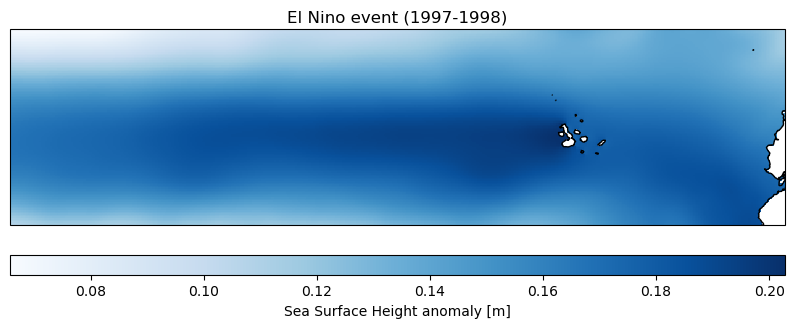

CPU times: user 1.54 s, sys: 377 ms, total: 1.92 s
Wall time: 1.02 s


In [7]:
_, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={"projection":  crs.Miller()},
)
zos_pacific_area_anomaly_1997_1998_mean.plot(
    ax=ax, 
    cmap="Blues", 
    transform=crs.PlateCarree(), 
    cbar_kwargs={"orientation": "horizontal", "pad": 0.05, "aspect": 40, "label": "Sea Surface Height anomaly [m]"},
)
ax.coastlines()
ax.set_title("El Nino event (1997-1998)")
plt.show()

## Other El Nino events

We want to see if other El Nino events can be found in the dataset time span. To do so, we average the sea surface height anomaly by month. Then, we further reduce it in space and plot it as a timeseries.

In [8]:
zos_pacific_area_anomaly_monthly_mean = zos_pacific_area_anomaly.resample(time="1M").mean()
zos_pacific_area_anomaly_monthly_mean_spatial_mean = zos_pacific_area_anomaly_monthly_mean.mean(dim=["latitude", "longitude"])
zos_pacific_area_anomaly_monthly_mean_spatial_mean

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


<xarray.DataArray 'zos' (time: 336)>
array([ 4.40077391e-03, -1.42602855e-03,  1.70006300e-03,  2.40247697e-02,
        4.79212962e-02,  4.49363403e-02, -5.75043913e-03, -2.96849385e-02,
       -8.78571253e-03,  6.18523825e-03, -8.84243939e-03, -1.13469269e-02,
       -3.69406827e-02, -8.01823288e-02, -8.83333758e-02, -7.41540119e-02,
       -4.76941988e-02, -1.14657590e-02, -4.51347753e-02, -4.72442135e-02,
       -1.99648645e-02,  1.91298071e-02,  5.67575842e-02,  5.90143278e-02,
        3.75837162e-02,  5.01682516e-03, -6.63755313e-02, -8.94013792e-02,
       -6.74342141e-02, -2.99530700e-02, -3.34213935e-02, -5.98208010e-02,
       -6.58568144e-02, -6.67103305e-02, -6.05908483e-02, -7.57564977e-02,
       -5.31056337e-02, -5.03040701e-02, -6.80902228e-02, -6.42946735e-02,
       -4.64131646e-02, -2.89985631e-02, -1.65178664e-02, -4.69804183e-02,
       -5.45921028e-02, -4.46157977e-02, -5.75926974e-02, -5.24473637e-02,
       -4.83668558e-02, -2.13852455e-03, -2.42799893e-03,  3.84106562e-02,
        1.13646254e-01,  1.62065521e-01,  1.83192641e-01,  1.41572058e-01,
        1.54378548e-01,  2.35746533e-01,  2.97812074e-01,  3.05293530e-01,
        1.84638679e-01,  1.03104547e-01,  5.54802492e-02,  3.90580595e-02,
        1.94745325e-02, -3.71824438e-03, -3.42478082e-02, -5.56304678e-02,
       -7.37036318e-02, -7.62799382e-02, -7.21148327e-02, -9.38088596e-02,
       -9.18634087e-02, -1.03997700e-01, -9.05008987e-02, -8.17122981e-02,
       -4.57395948e-02, -2.93431003e-02, -3.62682231e-02, -7.04730675e-02,
...
        4.20084968e-02,  4.52657901e-02,  5.62610067e-02,  7.36662671e-02,
        3.77615429e-02,  1.03870295e-02,  3.01833637e-02,  9.07830819e-02,
        1.33475617e-01,  1.50331169e-01,  1.12203397e-01,  1.06597267e-01,
        1.39395609e-01,  1.48626328e-01,  2.04453528e-01,  2.04849154e-01,
        1.47573397e-01,  1.20715603e-01,  3.58496793e-02, -2.17352975e-02,
       -4.15448849e-05,  1.28824245e-02, -1.31779648e-02, -1.85628235e-02,
       -1.04986317e-02, -1.14888502e-02, -5.54888835e-03,  1.34990513e-02,
        2.34150998e-02,  2.57791597e-02,  1.94091760e-02,  2.22403482e-02,
        3.71268764e-02,  4.13866974e-02,  3.13760377e-02, -1.76702641e-04,
       -2.89698858e-02, -2.23253388e-02, -2.75481809e-02, -2.63755471e-02,
       -1.44611252e-02, -1.43135125e-02, -1.67584363e-02,  1.05760796e-02,
        5.09033538e-02,  7.56695196e-02,  5.24430610e-02,  1.50186839e-02,
        2.77553611e-02,  9.48700085e-02,  1.16725944e-01,  1.00179099e-01,
        5.54853827e-02,  2.07669996e-02,  4.60396968e-02,  4.54602167e-02,
        3.18603814e-02,  2.60280538e-02,  4.07650223e-04, -7.19114672e-03,
       -7.46459514e-03,  3.28320041e-02,  7.49382153e-02,  6.38383552e-02,
        6.39289692e-02,  5.19850515e-02,  2.01624986e-02,  1.62181221e-02,
        1.14328731e-02, -3.18759936e-04,  6.60650525e-03, -3.65298777e-03,
       -1.78418271e-02, -1.83241107e-02, -2.42982842e-02, -6.82265218e-03],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1993-01-31 1993-02-28 ... 2020-12-31

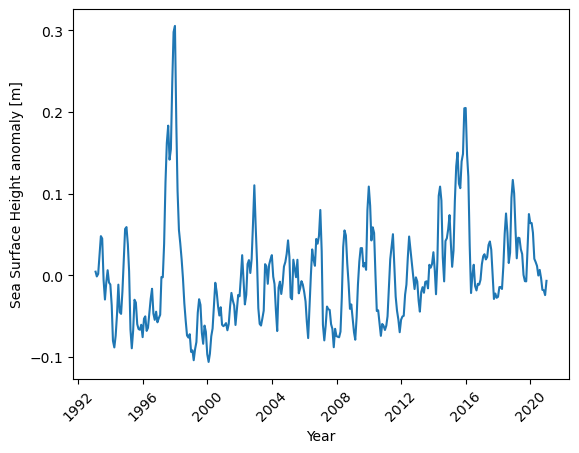

CPU times: user 651 ms, sys: 281 ms, total: 932 ms
Wall time: 121 ms


In [9]:
%%time

plt.plot(zos_pacific_area_anomaly_monthly_mean_spatial_mean['time'], zos_pacific_area_anomaly_monthly_mean_spatial_mean)
plt.xlabel('Year')
plt.ylabel('Sea Surface Height anomaly [m]')
plt.xticks(rotation=45)
plt.show()